In [1]:
!pip install torch torchvision datasets evaluate transformers[torch] --quiet

In [2]:
import pandas as pd
import os
import shutil
import torch
import random
import json
import pyarrow as pa
import numpy as np
import evaluate

from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split

from datasets import Dataset


from tqdm.notebook import tqdm
from torch.utils.data import DataLoader

In [3]:
component = 2
# mode = 'train'
mode = 'eval'

model_type = "distilbert-base-cased" if component == 1 else "distilbert-base-uncased"

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')
    data_dir = '/content/drive/MyDrive/Colab Notebooks/text_mining_re_data/'
else:
    data_dir = os.getcwd()

data_dir = os.path.join(data_dir, f'component_{component}')

train_raw = pd.read_json(os.path.join(data_dir, 'train_tm.json'))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
train_raw = train_raw[['annotations', 'data']]

In [6]:
# get all relations presented

relations = {}
for index, row in train_raw.iterrows():
    items = row['annotations'][0]['result']
    for item in items:
        if item['type'] == 'relation':
            if item.get('labels', None) is None:
                print(item)
            if len(item.get('labels', [])) != 0:
                relations[item['labels'][0]] = relations.get(item['labels'][0], 0) + 1

In [7]:
id2label = {i: rel for i, rel in enumerate(list(relations.keys()) + ['None'])}
label2id = {id2label[key]: key for key in id2label.keys()}

In [8]:
if mode == 'train':
    with open(os.path.join(data_dir, 'id2label.json'), 'w') as fp:
        json.dump(id2label, fp)
else:
    with open(os.path.join(data_dir, 'id2label.json'), 'r') as fp:
        id2label = json.load(fp)

    id2label = {int(key): id2label[key] for key in id2label.keys()}
    label2id = {id2label[key]: key for key in id2label.keys()}

In [9]:
id2label

{0: 'caused_by',
 1: 'happened_on',
 2: 'happened_during',
 3: 'solved_by',
 4: 'happened_at',
 5: 'done_by',
 6: 'refers_to',
 7: 'None'}

In [10]:
def existing_relation(relations , ent1_id, ent2_id):
    for rel in relations:
        if rel['from'] == ent1_id and rel['to'] == ent2_id:
            return rel
    return False

if component==1:
    def possible_relation(entities, ent1_id, ent2_id):
        ent1, ent2 = entities[ent1_id], entities[ent2_id]
        if ent1['entity'] == 'PLAYER' and ent2['entity'] in ['PLAYER', 'CLUB', 'NATIONALITY', 'COUNTRY', 'POSITION', 'DATE'] \
            or ent1['entity'] == 'CLUB' and ent2['entity'] in ['CLUB']:
            return True
        return False
else:
    def possible_relation(entities, ent1_id, ent2_id):
        ent1, ent2 = entities[ent1_id], entities[ent2_id]
        if ent1['entity'] == 'UNEXPECTED EVENT' and ent2['entity'] in ['EMPLOYEE', 'TIME', 'DATE', 'LOCATION', 'CAUSE', 'SOLUTION'] \
            or ent1['entity'] == 'EXPECTED EVENT' and ent2['entity'] in ['EMPLOYEE', 'TIME', 'DATE', 'LOCATION']\
            or ent1['entity'] == 'ACTIVITY' and ent2['entity'] in ['EMPLOYEE', 'TIME', 'DATE', 'LOCATION']\
            or ent1['entity'] == 'CAUSE' and ent2['entity'] in ['ACTIVITY']:
            return True
        return False

In [11]:
def get_relation_text(text, first, second):
    first_mark = '[{}]'.format(first['entity'])
    first_entity = first_mark + text[first['start']: first['end']] + first_mark
    second_mark = '[{}]'.format(second['entity'])
    second_entity = second_mark + text[second['start']: second['end']] + second_mark
    subtext = text[first['end']: second['start']]
    return first_entity + subtext + second_entity

In [12]:
def generate_possible_relations(entities, entities_list, relations=None, ratio=None):
    entities_list.sort(key=lambda x: x[1])
    possible_relations = []
    for i, ent_one in enumerate(entities_list):
        for j, ent_two in enumerate(entities_list[i+1:i+11]): # change to 10 entities
            if possible_relation(entities, ent_one[0], ent_two[0]) and \
             ((relations is not None and not existing_relation(relations, ent_one[0], ent_two[0])) \
              or relations is None):
                possible_relations.append([ent_one[0], ent_two[0]])
    if ratio:
        possible_relations = random.sample(possible_relations, min(len(possible_relations), ratio * len(relations)))
    return possible_relations


In [13]:
def generate_train_relations(documents):
    texts = []
    labels = []
    for i, doc in documents.iterrows():
        annotations = doc['annotations'][0]['result']
        entities = {}
        entities_list = []
        relations = []
        text = doc['data']['text']
        for item in annotations:
            if item['type'] == 'labels':
                entities[item['id']] = {'start': item['value']['start'], 'end': item['value']['end'], 'entity': item['value']['labels'][0]}
                entities_list.append([item['id'], item['value']['start'], item['value']['end'], item['value']['labels'][0]])
            else:
                if len(item.get('labels', [])) != 0:
                    if entities[item['from_id']]['start'] < entities[item['to_id']]['start']:
                        relations.append({'from': item['from_id'], 'to': item['to_id'], 'label': item['labels'][0]})
                    else:
                        relations.append({'from': item['to_id'], 'to': item['from_id'], 'label': item['labels'][0]})

        entities_list = sorted(entities_list, key=lambda x: x[1])

        none_relations = generate_possible_relations(entities, entities_list, relations=relations, ratio=5)
        for relation in none_relations:
            first = entities[relation[0]]
            second = entities[relation[1]]
            texts.append(get_relation_text(text, first, second))
            labels.append('None')

        for relation in relations:
            first = entities[relation['from']]
            second = entities[relation['to']]
            texts.append(get_relation_text(text, first, second))
            labels.append(relation['label'])

    return pd.DataFrame(data={'text': texts, 'label':labels})

In [14]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

In [15]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained(model_type)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [16]:
train, val = train_test_split(train_raw, test_size=0.2, random_state=42)

In [17]:
print(train.shape, val.shape)

(24, 2) (6, 2)


In [18]:
train_dataset = generate_train_relations(train)
train_dataset['label'] = train_dataset.apply(lambda x: label2id[x['label']], axis=1)
train_dataset = Dataset(pa.Table.from_pandas(train_dataset))

train_dataset = train_dataset.map(tokenize_function, batched=True)

val_dataset = generate_train_relations(val)
val_dataset['label'] = val_dataset.apply(lambda x: label2id[x['label']], axis=1)
val_dataset = Dataset(pa.Table.from_pandas(val_dataset))

val_dataset = val_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/380 [00:00<?, ? examples/s]

Map:   0%|          | 0/70 [00:00<?, ? examples/s]

In [19]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    metrics = {'f1_score_macro': f1_score(labels, predictions, average='macro'),
               'accuracy': accuracy_score(labels, predictions)}
    return metrics

In [20]:
model_dir = os.path.join(data_dir, 'models')

if mode == 'train':

    model = AutoModelForSequenceClassification.from_pretrained(
        model_type, num_labels=len(id2label.keys()), id2label=id2label, label2id=label2id
    )
    if os.path.exists(model_dir):
        if os.listdir(model_dir):
            shutil.rmtree(model_dir)
            os.makedirs(model_dir)
    else:
        os.makedirs(model_dir)
else:
    model = AutoModelForSequenceClassification.from_pretrained(
        os.path.join(model_dir, "best_model"), num_labels=len(id2label.keys()), id2label=id2label, label2id=label2id
    ).to(device)

In [21]:
BATCH_SIZE = 32 if component==1 else 8
EPOCHS = 10 if component==1 else 10

In [22]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
eval_save_steps = 100 if component==1 else 50

training_args = TrainingArguments(output_dir=model_dir,
    evaluation_strategy='steps',
    eval_steps=eval_save_steps,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    save_strategy='steps',
    save_steps=eval_save_steps,
    save_total_limit = 1,
    load_best_model_at_end=True,
    metric_for_best_model = 'f1_score_macro')

In [23]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(3, 0.0)]
)

In [24]:
if mode == 'train':
    trainer.train()
    trainer.save_model(os.path.join(model_dir, 'best_model'))

In [25]:
def get_latest_annotations(test_raw):
    def get_latest(x):
        latest = x[0]
        for annot in x[1:]:
            if annot['updated_at'] > latest['updated_at']:
                latest = annot
        return [latest]
    test_raw['annotations'] = test_raw['annotations'].apply(get_latest)
    return test_raw

In [26]:
test_raw = pd.read_json(os.path.join(data_dir, 'test_tm.json'))
test_raw = test_raw[['annotations', 'data']]
test_raw = get_latest_annotations(test_raw.copy())

In [27]:
test_dataset = generate_train_relations(test_raw)
test_dataset['label'] = test_dataset.apply(lambda x: label2id[x['label']], axis=1)
test_dataset = Dataset(pa.Table.from_pandas(test_dataset))

test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/112 [00:00<?, ? examples/s]

In [29]:
trainer.evaluate(train_dataset)

{'eval_loss': 0.17604950070381165,
 'eval_f1_score_macro': 0.8425936434865007,
 'eval_accuracy': 0.9657894736842105,
 'eval_runtime': 6.7619,
 'eval_samples_per_second': 56.197,
 'eval_steps_per_second': 7.099}

In [30]:
trainer.evaluate(val_dataset)

{'eval_loss': 0.1612551510334015,
 'eval_f1_score_macro': 0.8666666666666667,
 'eval_accuracy': 0.9857142857142858,
 'eval_runtime': 1.1775,
 'eval_samples_per_second': 59.449,
 'eval_steps_per_second': 7.643}

In [28]:
trainer.evaluate(test_dataset)

{'eval_loss': 0.3550504744052887,
 'eval_f1_score_macro': 0.8314141414141414,
 'eval_accuracy': 0.9464285714285714,
 'eval_runtime': 2.8243,
 'eval_samples_per_second': 39.656,
 'eval_steps_per_second': 4.957}

In [31]:
predicted_labels_encoded = np.argmax(trainer.predict(test_dataset).predictions, axis=-1)

In [32]:
true_labels_encoded = test_dataset['label']
x_labels = []
for i in range(len(id2label)):
    x_labels.append(id2label[i])

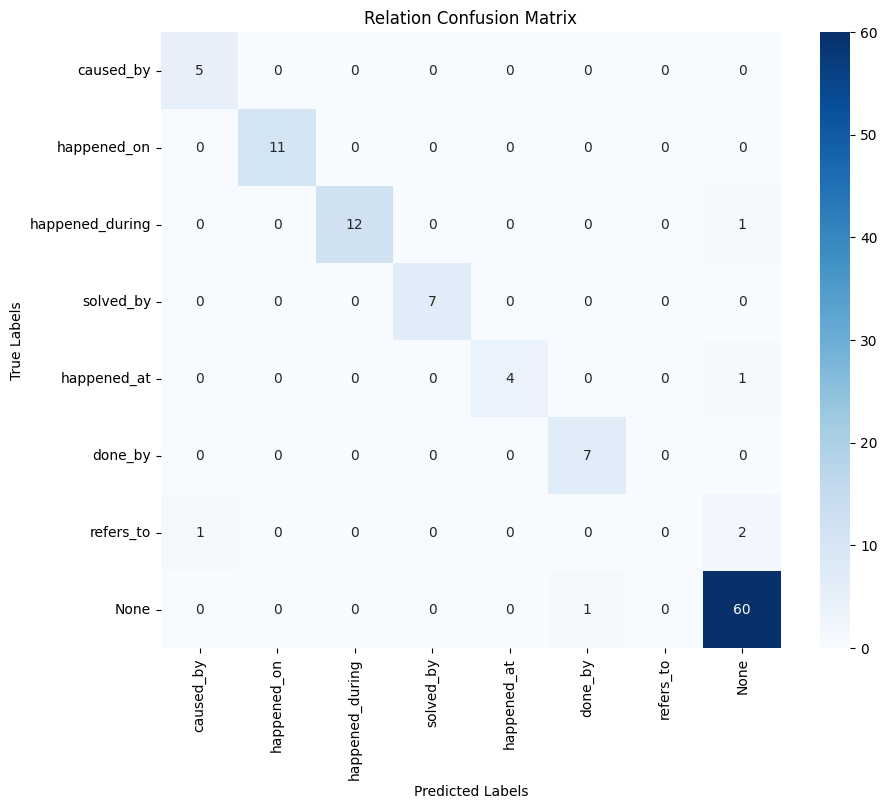

In [33]:
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

cm = metrics.confusion_matrix(true_labels_encoded, predicted_labels_encoded)
# cm = cm[:-1,:-1]

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=x_labels, yticklabels=x_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Relation Confusion Matrix")
plt.show()